In [1]:
from qiskit import * 
from qiskit import Aer
from qiskit.aqua.operators import StateFn
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import Operator
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
########  パラメータ  #############
nqubit = 3 ## qubitの数
c_depth = 3 ## circuitの深さ

# 横磁場イジングモデルのパラメーター
time_step = 0.77  ## ランダムハミルトニアンによる時間発展の経過時間
h = 3 # 外部磁場

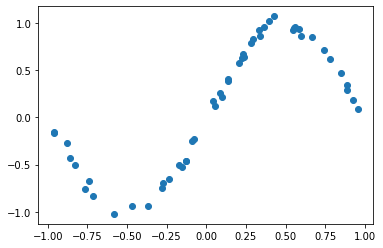

In [3]:
#### 教師データを準備

## [x_min, x_max]でランダムにnum_x_train個の点を生成
x_min = - 1.; x_max = 1.;
num_x_train = 50

## 学習したい1変数関数
func_to_learn = lambda x: np.sin(x*np.pi)

random_seed = 0 ## 乱数のシード
np.random.seed(random_seed) ## 乱数発生器の初期化

x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定しノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

In [4]:
# 初期状態の準備
q = QuantumCircuit(nqubit)
backend = Aer.get_backend('statevector_simulator')
result = execute(q, backend).result().get_statevector(q, decimals=3)
print(result)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [5]:
# xをエンコード
def U_in(x):
    U = QuantumCircuit(nqubit)
    
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)
    
    for i in range(nqubit):
        U.ry(angle_y, i)
        U.rz(angle_z, i)
        
    return U

In [6]:
## 基本ゲート
backend = Aer.get_backend('unitary_simulator')

I_mat = np.eye(2, dtype=complex)

q = QuantumCircuit(1)
q.x(0)
job = execute(q, backend)
X_mat = job.result().get_unitary(q, decimals=3)

q = QuantumCircuit(1)
q.z(0)
job = execute(q, backend)
Z_mat = job.result().get_unitary(q, decimals=3)

In [7]:
##### quantum native dojoから引用　#####
## fullsizeのgateをつくる関数.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...] を受け取り,
    関係ないqubitにIdentityを挿入して
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    という(2**nqubit, 2**nqubit)行列をつくる.
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## 1-qubit gateを並べてnp.kronでreduceする
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## 何もないsiteはidentity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

In [8]:
##### quantum native dojoから引用　#####
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## -1~1の乱数
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## 対角化して時間発展演算子をつくる. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

In [9]:
## 時間発展演算子が2**3=8次の行列であることを確認
time_evol_op.shape

(8, 8)

In [11]:
## 変分量子回路U(\theta)の構築
def U_out(param_list):
    qc = QuantumCircuit(nqubit)

    for d in range(c_depth):
        # 時間発展演算子を回路に組み込む
        qc.unitary(Operator(time_evol_op), range(nqubit), label="time_evol")

        # パラメーター回転ゲートを導入
        for i in range(nqubit):
            qc.rx(-2*param_list[3*i], i)            
            qc.rz(-2*param_list[3*i+1], i)
            qc.rx(-2*param_list[3*i+2], i)
    return qc

In [12]:
# モデルの出力
# 出力状態において最初の量子ビットのZでの期待値を計算
from qiskit.aqua.operators import Z, I

def qcl_pred(x, param_list):
    # 回路を一つにまとめる
    qcl_cirq = U_in(x) + U_out(param_list)
    obs = Z ^ I ^ I
    psi = StateFn(qcl_cirq)
    expectation_value = (~psi @ obs @ psi).eval()
    return expectation_value.real

In [13]:
# コスト関数Lを計算
def cost_func(theta):

    # num_x_train個のデータについて計算
    y_pred = [qcl_pred(x, theta) for x in x_train]

    # quadratic loss
    L = ((y_pred - y_train)**2).mean()

    return L

In [14]:
# パラメータthetaの初期値theta_initにおけるコスト関数の値
# theta: 長さc_depth * nqubit * 3のndarray
theta_init = [2.0 * np.pi * np.random.rand() for i in range(c_depth*nqubit*3)]
cost_func(theta_init)

0.3060054027687377

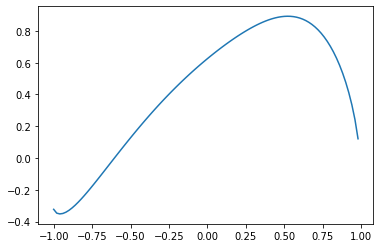

In [15]:
# パラメータthetaの初期値のもとでのグラフ
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, theta_init) for x in xlist]
plt.plot(xlist, y_init)

In [16]:
from scipy.optimize import minimize
# 学習(注意:数時間かかりました)
result = minimize(cost_func, theta_init, method='Nelder-Mead')
theta_opt = result.x
print(theta_opt)

[  5.96012056   3.89750242   2.18686922   4.44030336   0.5347801
   2.06940148   4.28237217   1.97531992   4.0723676    4.84521954
   3.9452004   -2.25667459 -11.05520732   4.30463541  -2.59443572
   7.54209131 -14.08115219   2.1968519   10.67669888   2.68849223
   0.85690569   8.89131196  19.22181787   0.14023356   2.08058438
  -0.4499139    5.62937156]


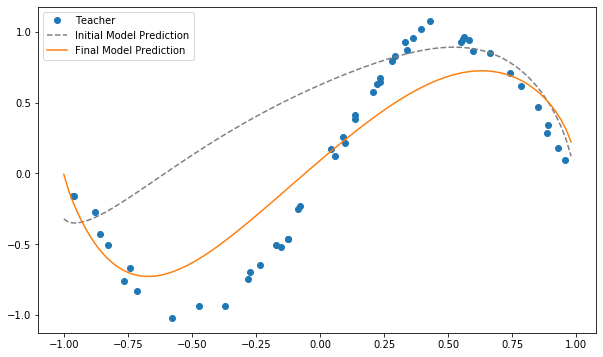

In [17]:
# プロット
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# パラメータθの初期値のもとでのグラフ
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# モデルの予測値
y_pred = np.array([qcl_pred(x, theta_opt) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()